## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random
import copy

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [145]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

final_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc')

In [366]:
aaron_file = scipy.io.loadmat('../aaron_aht_stuff/monthly_AHT/1980_6_AHT.mat')
aaron_raw = scipy.io.loadmat('../aaron_aht_stuff/monthly_data/1980_6means.mat')

aaron_mmc = aaron_file['MME']

In [323]:
aaron_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AHT', 'AHT_dry', 'AHT_moist', 'AHT_pot', 'E_bar', 'ME_bar', 'MME', 'PE_bar', 'SE', 'SE_bar', 'SE_dry', 'SE_dry_vert', 'SE_moist', 'SE_moist_vert', 'SE_pot', 'SE_pot_vert', 'TE', 'TE_dry', 'TE_dry_vert', 'TE_moist', 'TE_moist_vert', 'TE_pot', 'TE_pot_vert', 'V_bar', 'V_barotropic', 'lat', 'lev'])

In [324]:
aaron_weight = scipy.io.loadmat('../aaron_aht_stuff/CLIM_MASKS.mat')

### Load stream functions

In [325]:
strm_ds = xr.open_dataset('strm_functions.nc').sel(time=slice('1980','2018'))

### Raw data

In [385]:
raw_data = xr.open_dataset('../era5_raw_data/monthly_data/monthly_ave_data1980.nc')

raw_data['mse'] = raw_data.t * cp + raw_data.q*L + raw_data.z

In [386]:
calc_data = raw_data.isel(time=5)


### Now try to make the MMC data

In [357]:
temp_v = calc_data.v.values
temp_v[zon_norms==0] = 0

In [330]:
#zon_norms = np.load('../Calculate_AHT/zonal_norms.npy')

#weight = np.load('../Calculate_AHT/aht_weights.npy')

zon_norms = aaron_weight['ZON_NORM']
weight = aaron_weight['WEIGHT'] * g
weight_normed = weight / np.nanmax(weight)
weight_zonal_ave = aaron_weight['ZON_WEIGHT'] * g


#weight_zonal_ave[np.isnan(weight_zonal_ave)] = 0
#zon_norms[np.isnan(zon_norms)] = 0
#weight_zonal_ave = np.nanmean(weight, axis=2)
    
#Now make sure we don't count nan levels in zonal mean
#nan_count=np.isnan(weight).sum(axis=2)
#nan_count=1-(nan_count/len(weight[0,0,:]))
#weight_zonal_ave_new=weight_zonal_ave*nan_count
    
temp_zon_mean = np.sum(calc_data.t * cp * zon_norms, axis=2)
sphum_zon_mean = np.sum(calc_data.q * L * zon_norms, axis=2)
geo_pot_zon_mean = np.sum(calc_data.z * zon_norms, axis=2)
mse_zon_mean = np.sum(calc_data.mse * zon_norms, axis=2)
vcomp_zon_mean = np.sum(calc_data.v * zon_norms, axis=2)

#vcomp_zon_mean = np.sum(calc_data.v * weight_normed, axis=2)
    
temp_vert_ave = np.sum(temp_zon_mean * weight_zonal_ave, axis=0) / np.sum(weight_zonal_ave, axis=0)
sphum_vert_ave = np.sum(sphum_zon_mean * weight_zonal_ave, axis=0) / np.sum(weight_zonal_ave, axis=0)
z_vert_ave = np.sum(geo_pot_zon_mean * weight_zonal_ave, axis=0) / np.sum(weight_zonal_ave, axis=0)
mse_vert_ave = np.sum(mse_zon_mean * weight_zonal_ave, axis=0) / np.sum(weight_zonal_ave, axis=0)
vcomp_vert_ave = np.sum(vcomp_zon_mean * weight_zonal_ave, axis=0) / np.sum(weight_zonal_ave, axis=0)

temp_mmc = temp_zon_mean #- np.expand_dims(temp_vert_ave, 0)
sphum_mmc = sphum_zon_mean #- np.expand_dims(sphum_vert_ave, 0)
z_mmc = geo_pot_zon_mean #- np.expand_dims(z_vert_ave, 0)
mse_mmc = mse_zon_mean #- np.expand_dims(mse_vert_ave, 0)
vcomp_mmc = vcomp_zon_mean - np.expand_dims(vcomp_vert_ave, 0)
    
moc_tot_int = mse_mmc * vcomp_mmc * weight_zonal_ave
moc_temp_int = temp_mmc * vcomp_mmc * weight_zonal_ave
moc_geo_pot_int = z_mmc * vcomp_mmc * weight_zonal_ave
moc_dry_int = moc_temp_int + moc_geo_pot_int
moc_moist_int = sphum_mmc * vcomp_mmc * weight_zonal_ave

mmc_tot = np.sum(moc_tot_int, axis=0)
mmc_temp = np.sum(moc_temp_int, axis=0)
mmc_geo_pot = np.sum(moc_geo_pot_int, axis=0)
mmc_dry = np.sum(moc_dry_int, axis=0)
mmc_moist = np.sum(moc_moist_int, axis=0)

aaron_mmc_direct = weight_zonal_ave * (aaron_file['V_bar']*aaron_file['E_bar']) * geometry

In [400]:
v_test = np.zeros((37, 361))
v_test_zon_mean = np.zeros((37, 361))
v_barotropic = np.zeros(361)

for i in range(37):
    for j in range(361):

        v_test_zon_mean[i,j] = np.sum(zon_norms[i,j,:] * calc_data.v.values[i,j,:])
        
        #print(np.shape(np.atleast_2d(zon_norms[i,j,:]).T))
        #print(np.shape(np.atleast_2d(calc_data.v.values[i,j,:])))

        #v_test_zon_mean[i,j] = np.matmul(np.atleast_2d(calc_data.v.values[i,j,:]), np.atleast_2d(zon_norms[i,j,:]).T)
        #v_test_zon_mean[i,j] = np.matmul(np.atleast_2d(temp_v[i,j,:]), np.atleast_2d(zon_norms[i,j,:]).T)
        
for i in range(361):
    
        v_barotropic[i] = np.mean(v_test_zon_mean[:,i] * weight_zonal_ave[:,i])/ np.mean(weight_zonal_ave[:,i])
        
        v_test[:,i] = v_test_zon_mean[:,i] - v_barotropic[i]
        

v_test2 = calc_data.v.mean('longitude').values

In [401]:
aaron_v = aaron_file['V_bar']
aaron_mse = aaron_file['E_bar']

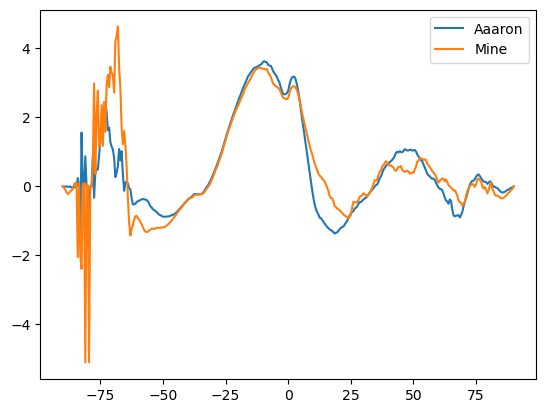

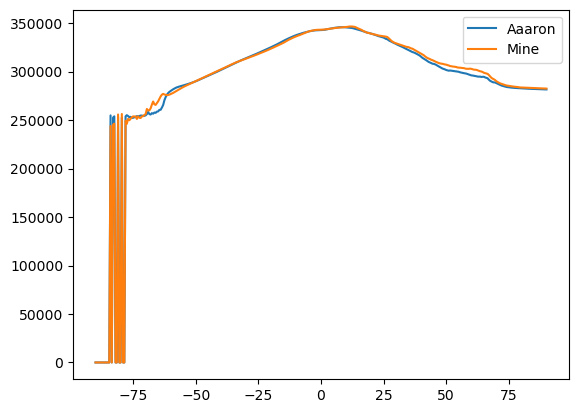

In [406]:
which_lev = 36

plt.plot(lats, aaron_v[which_lev,:], label='Aaaron')
plt.plot(lats, vcomp_mmc[which_lev,:], label='Mine')
#plt.plot(lats, v_test[which_lev,:], label='test')
#plt.plot(lats, v_test_zon_mean[which_lev,:] - aaron_file['V_barotropic'].flatten(), label='Test w/ aaron baro')
#plt.plot(lats, v_test2[which_lev,:] - aaron_file['V_barotropic'].flatten(), label='Test2 w/ aaron baro')

#plt.plot(lats, v_test2[which_lev,:], label='Straight mean')
#plt.plot(lats, v_test_zon_mean[which_lev,:], label='Mine no baro')
#plt.plot(lats, aaron_v[which_lev,:] + aaron_file['V_barotropic'].flatten(), label='Aaaron no baro')   

plt.legend(loc=0)
plt.show()

plt.plot(lats, aaron_mse[which_lev,:], label='Aaaron')
plt.plot(lats, mse_mmc.values[which_lev,:], label='Mine')

plt.legend(loc=0)
plt.show()

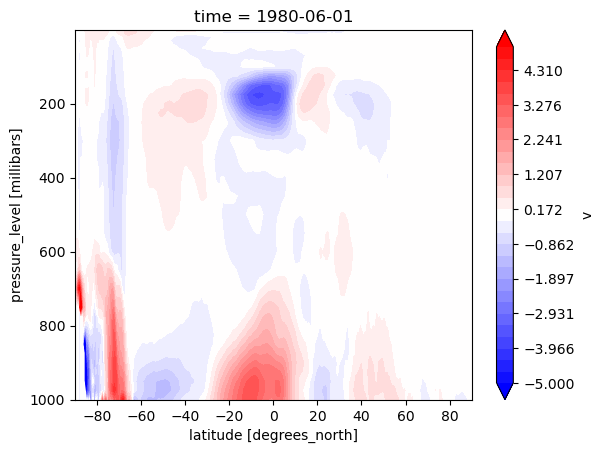

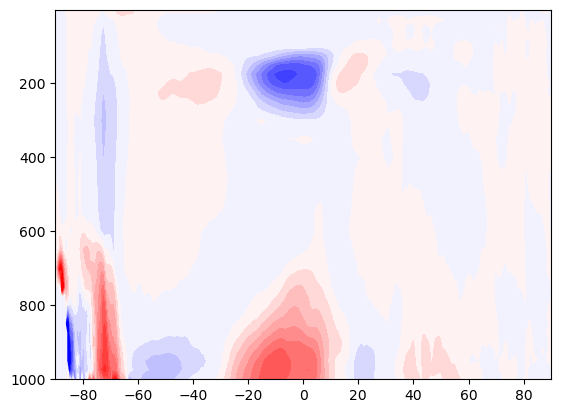

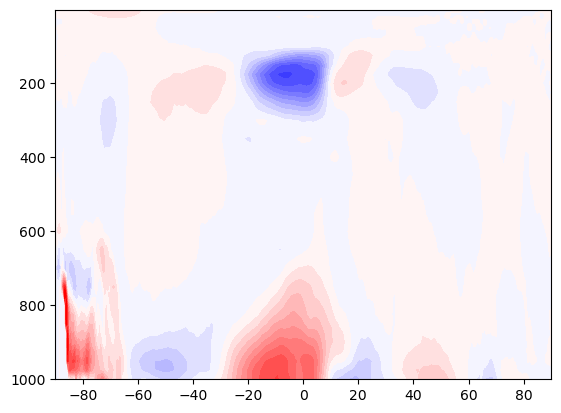

In [403]:
(vcomp_mmc).plot.contourf(vmin = -5, vmax=5, levels=30, cmap='bwr')
plt.gca().invert_yaxis()
plt.show()

plt.contourf(lats, levels, v_test, vmin = -5, vmax=5, levels=30, cmap='bwr')
plt.gca().invert_yaxis()
plt.show()

plt.contourf(lats, levels, aaron_v, vmin = -5, vmax=5, levels=30, cmap='bwr')
plt.gca().invert_yaxis()
plt.show()

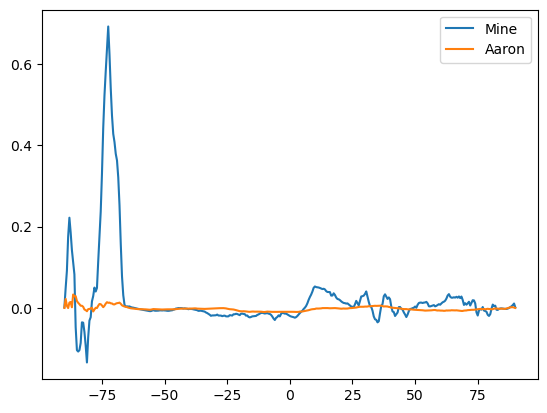

In [335]:
plt.plot(lats, v_barotropic, label='Mine')
plt.plot(lats, aaron_file['V_barotropic'].flatten(), label='Aaron')

plt.legend(loc=0)
plt.show()

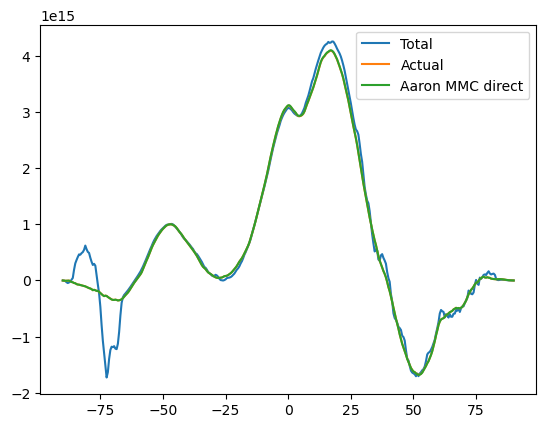

In [144]:
plt.plot(lats, mmc_tot * geometry, label='Total')
#plt.plot(lats, mmc_temp * geometry, label='Temp')
#plt.plot(lats, mmc_moist * geometry, label='Moist')
#plt.plot(lats, mmc_geo_pot * geometry, label='Geo Pot')

plt.plot(lats, final_ds.mmc_aht.sel(time=slice('1980-01-01', '1980-01-31')).mean(['time']), label='Actual')
#plt.plot(lats, final_ds.mmc_aht_moist.sel(time=slice('1980-01-01', '1980-12-31')).mean(['time']), label='Actual Moist')
#plt.plot(lats, final_ds.mmc_aht_dry.sel(time=slice('1980-01-01', '1980-12-31')).mean(['time']), label='Actual Dry')
#plt.plot(lats, final_ds.mmc_aht_pot.sel(time=slice('1980-01-01', '1980-12-31')).mean(['time']), label='Actual Pot')

plt.plot(lats, np.sum(aaron_mmc_direct, axis=0), label='Aaron MMC direct')

plt.legend(loc=0)
plt.show()

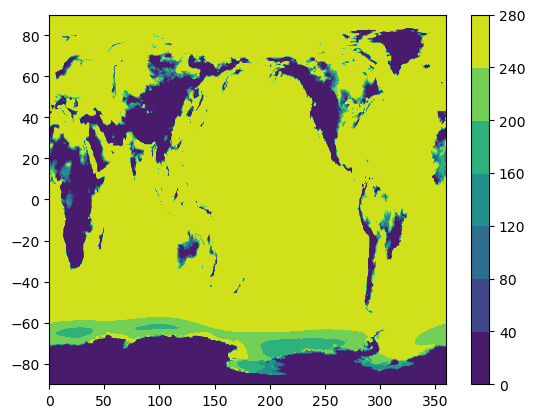

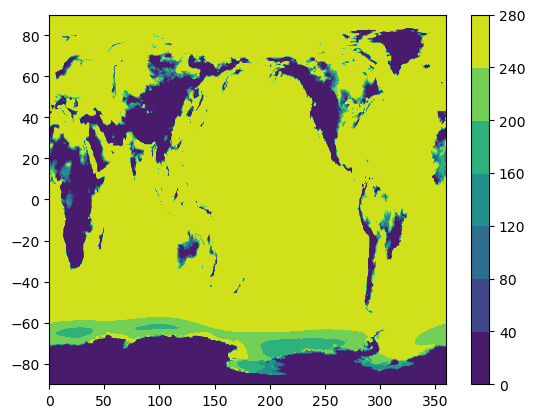

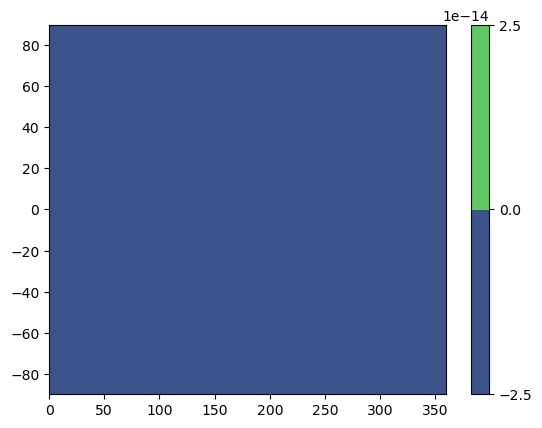

In [13]:
plt.contourf(lons, lats, weight[35,:,:] / g)

plt.colorbar()
plt.show()

plt.contourf(lons, lats, aaron_weight['WEIGHT'][35,:,:])

plt.colorbar()
plt.show()

plt.contourf(lons, lats, (weight[35,:,:] / g) - aaron_weight['WEIGHT'][35,:,:])

plt.colorbar()
plt.show()

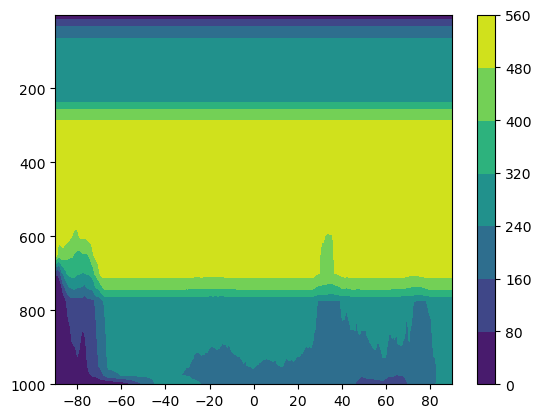

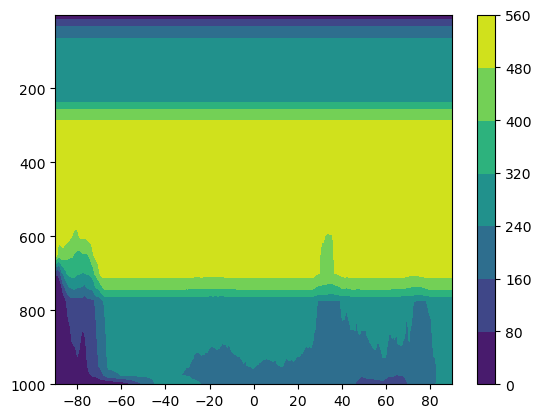

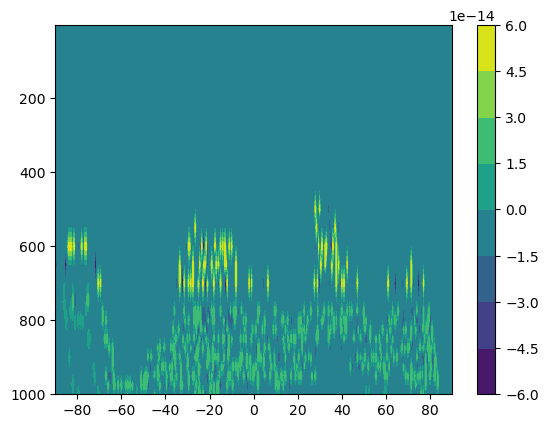

In [14]:
plt.contourf(lats, levels, aaron_weight['ZON_WEIGHT'])

plt.gca().invert_yaxis()

plt.colorbar()

plt.show()

plt.contourf(lats, levels, weight_zonal_ave / g)

plt.gca().invert_yaxis()

plt.colorbar()

plt.show()

plt.contourf(lats, levels, (weight_zonal_ave / g) - aaron_weight['ZON_WEIGHT'])

plt.gca().invert_yaxis()

plt.colorbar()

plt.show()

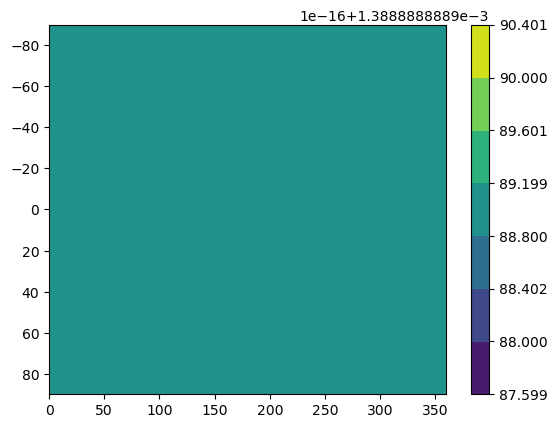

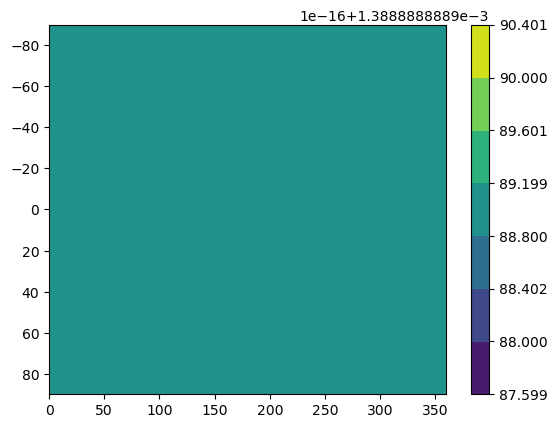

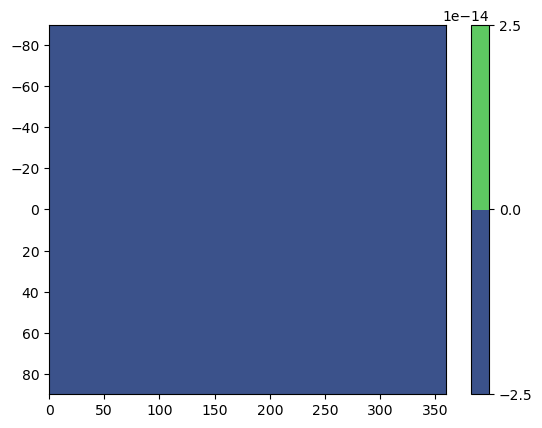

In [229]:
test_lev = 20


plt.contourf(lons, lats, aaron_weight['ZON_NORM'][test_lev,:,:])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.contourf(lons, lats, zon_norms[test_lev,:,:])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.contourf(lons, lats, zon_norms[test_lev,:,:] - aaron_weight['ZON_NORM'][test_lev,:,:])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [8]:
ps_raw = xr.open_dataset('../era5_raw_data/average_surf_pres.nc')

In [9]:
pres_halfs = copy.deepcopy(levels)

pres_halfs_dif = (np.asarray(pres_halfs[1:]) + np.asarray(pres_halfs[:-1])) / 2
final_pres_halfs = xr.DataArray(np.append(np.insert(pres_halfs_dif,0,0), 1013))

In [10]:
weight=np.zeros((len(levels),len(lats)))

ps_zonal=ps_raw.sp.mean(['lon']).values #Surface pressure
    
#pres_half_new_bot = np.expand_dims(pres_halfs, 1)
pres_half_new_bot = np.zeros((38, len(lats)))
for i in range(len(lats)):
    pres_half_new_bot[:,i] = final_pres_halfs
                
#pres_half_new_bot_tiled = np.tile(final_pres_halfs, len(lats))
#pres_half_new_bot = np.resize(pres_half_new_bot_tiled, (38, len(lats)))
#pres_half_new_bot=copy.deepcopy(pres_halfs.expand_dims({'lat':len(lat)},1).values)
    

#making it so our pres_half bottom layer is surface pressure, not 1000hPa
for i in range(0,len(lats),1):
    pres_half_new_bot[-1,i]=ps_zonal[i]/100
    weight[:,i]=np.diff(100*pres_half_new_bot[:,i])
    for k in range(0,len(levels),1):
        if weight[k,i] < 0:
            weight[k,i]=0
                
dummy_weight = np.load('../Calculate_AHT/aht_weights.npy')

#Now make sure we don't count nan levels in zonal mean   
nan_count=np.isnan(dummy_weight).sum(axis=2)
nan_count=1-(nan_count/len(lons))

#CHOOSE WEIGHT
#weight_new=weight*nan_count

weight = np.load('../Calculate_AHT/aht_weights.npy')
weight[np.isnan(weight)] = 0
weight_zonal_ave = np.nanmean(weight, axis=2)
weight_new = weight_zonal_ave * nan_count

In [11]:
#nan_maker = dummy_weight / dummy_weight
nan_maker = copy.deepcopy(dummy_weight)
nan_maker[~np.isnan(nan_maker)] = 1

In [12]:
vcomp_raw = raw_data.v.isel(time=1).values
mse_raw = raw_data.mse.isel(time=1).values

#vcomp_w_nans = vcomp_raw * nan_maker
#mse_w_nans = mse_raw * nan_maker

#vcomp_zonal_ave = np.nanmean(vcomp_w_nans, axis=2)
#mse_zonal_ave = np.nanmean(mse_w_nans, axis=2)

vcomp_raw[np.isnan(dummy_weight)] = np.nan
mse_raw[np.isnan(dummy_weight)] = np.nan

vcomp_zonal_ave = np.nanmean(vcomp_raw, axis=2)
mse_zonal_ave = np.nanmean(mse_raw, axis=2)

<ipython-input-12-e4f2cb5dd836>:13: RuntimeWarning: Mean of empty slice
  vcomp_zonal_ave = np.nanmean(vcomp_raw, axis=2)
<ipython-input-12-e4f2cb5dd836>:14: RuntimeWarning: Mean of empty slice
  mse_zonal_ave = np.nanmean(mse_raw, axis=2)


In [13]:
vcomp_vert_ave = np.nanmean(vcomp_zonal_ave * weight_new, axis=0) / np.nanmean(weight_new, axis=0)
mse_vert_ave = np.nanmean(mse_zonal_ave * weight_new, axis=0) / np.nanmean(weight_new, axis=0)

In [14]:
vcomp_final = vcomp_zonal_ave - vcomp_vert_ave[None,:]
mse_final = mse_zonal_ave - mse_vert_ave[None,:]

In [15]:
#vcomp_final[np.isnan(vcomp_final)] = 0
#mse_final[np.isnan(mse_final)] = 0

mmc_aht = np.nansum(vcomp_final * mse_final * weight_new, axis=0)

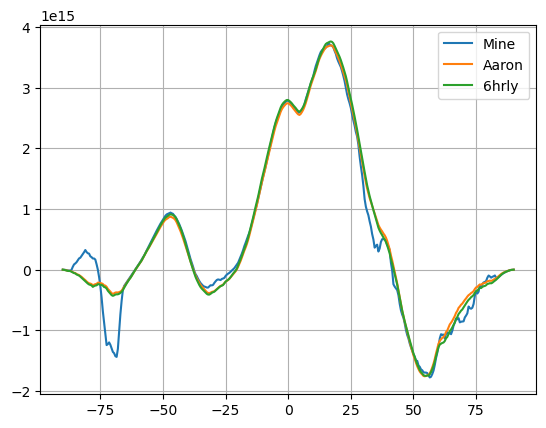

In [19]:
plt.plot(lats, mmc_aht * geometry, label='Mine')
plt.plot(lats, aaron_mmc.flatten(), label='Aaron')
plt.plot(lats, aht_ds.mmc_aht.sel(time=slice('1980-02-01', '1980-02-29')).mean(['time']), label='6hrly')

plt.grid()

plt.legend(loc=0)

plt.show()

In [401]:
weight = np.load('../Calculate_AHT/aht_weights.npy')

vcomp_raw = raw_data.v.isel(time=1).values
mse_raw = raw_data.mse.isel(time=1).values

vcomp_weighted = vcomp_raw * weight
mse_weighted = mse_raw * weight

In [432]:
weight = np.load('../Calculate_AHT/aht_weights.npy')

#Now make sure we don't count nan levels in zonal mean
nan_count=np.isnan(weight).sum(axis=2)

nan_count=1-(nan_count/len(weight[0,0,:]))

weight[np.isnan(weight)] = 0

weight_zonal_ave = np.nanmean(weight, axis=2)

#Now make sure we don't count nan levels in zonal mean
weight_zonal_ave_new=weight_zonal_ave*nan_count
weight_new = weight_zonal_ave
    


In [433]:
zon_norms = np.load('../Calculate_AHT/zonal_norms.npy')

In [434]:
vcomp_raw = raw_data.v.isel(time=1).values
mse_raw = raw_data.mse.isel(time=1).values

In [238]:
#dummy_weight = np.load('../Calculate_AHT/aht_weights.npy')

#nan_maker = dummy_weight / dummy_weight

#vcomp_zonal_time_mean = np.nanmean(vcomp_w_nans, axis=2)
#mse_zonal_time_mean = np.nanmean(mse_w_nans, axis=2)

In [435]:
vcomp_zonal_time_mean = np.nansum(vcomp_raw * zon_norms, axis=2)
mse_zonal_time_mean = np.nansum(mse_raw * zon_norms, axis=2)

In [240]:
#vcomp_zonal_time_mean = np.mean(vcomp_raw, axis=2)
#mse_zonal_time_mean = np.mean(mse_raw, axis=2)

In [436]:
#vcomp_vert_ave = np.nanmean(vcomp_zonal_time_mean * weight_zonal_ave, axis=0) / np.nanmean(weight_zonal_ave, axis=0)
#mse_vert_ave = np.nanmean(mse_zonal_time_mean * weight_zonal_ave, axis=0) / np.nanmean(weight_zonal_ave, axis=0)

vcomp_vert_ave = np.nanmean(vcomp_zonal_time_mean * weight_new, axis=0) / np.nanmean(weight_new, axis=0)
mse_vert_ave = np.nanmean(mse_zonal_time_mean * weight_new, axis=0) / np.nanmean(weight_new, axis=0)

In [437]:
#vcomp_final = vcomp_zonal_time_mean - vcomp_vert_ave[:,None,:]
#mse_final = mse_zonal_time_mean - mse_vert_ave[:,None,:]

vcomp_final = vcomp_zonal_time_mean - np.expand_dims(vcomp_vert_ave, 0)
mse_final = mse_zonal_time_mean - np.expand_dims(mse_vert_ave, 0)

In [438]:
#mmc_aht = np.nansum(vcomp_final * mse_final * weight_zonal_ave_new, axis=0)
mmc_aht = np.nansum(vcomp_final * mse_final * weight_new, axis=0)

In [439]:
aaron_file = scipy.io.loadmat('../aaron_aht_stuff/monthly_AHT/1980_2_AHT.mat')

aaron_mmc = aaron_file['MME']

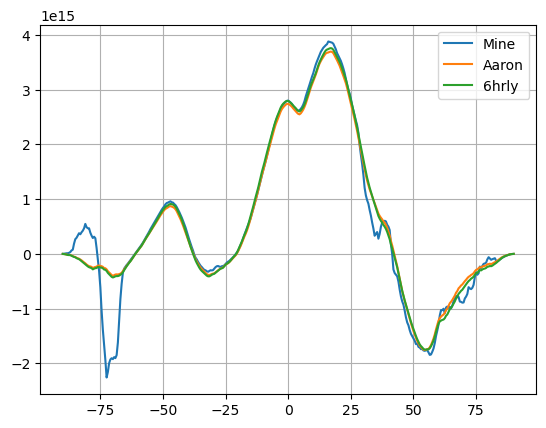

In [440]:
plt.plot(lats, mmc_aht * geometry, label='Mine')
plt.plot(lats, aaron_mmc.flatten(), label='Aaron')
plt.plot(lats, aht_ds.mmc_aht.sel(time=slice('1980-02-01', '1980-02-29')).mean(['time']), label='6hrly')

plt.grid()

plt.legend(loc=0)

plt.show()

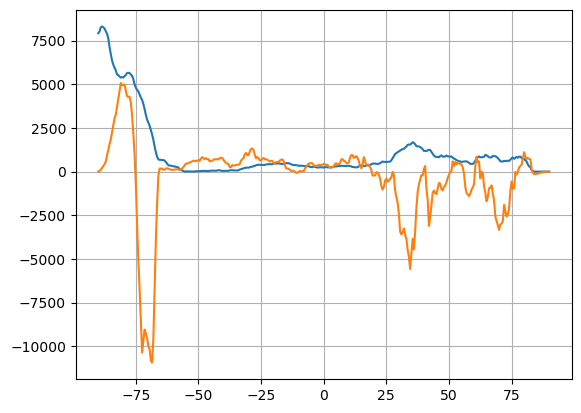

In [246]:
plt.plot(lats, np.sum(np.isnan(nan_maker), axis=(0, 2)))

plt.plot(lats, ((mmc_aht * geometry) - aaron_mmc.flatten()) / 1e11, label='Mine')
#plt.plot(lats, aaron_mmc.flatten(), label='Aaron')

plt.grid()

plt.show()

In [25]:
mmc_aht_test = np.zeros((30, len(lats)))
for i in range(30):

    new_raw_v = xr.open_dataset('../era5_raw_data/00/2019.v_component_of_wind.nc').isel(time=i)
    new_raw_t = xr.open_dataset('../era5_raw_data/00/2019.temperature.nc').isel(time=i)
    new_raw_q = xr.open_dataset('../era5_raw_data/00/2019.specific_humidity.nc').isel(time=i)
    new_raw_z = xr.open_dataset('../era5_raw_data/00/2019.geopotential.nc').isel(time=i)

    new_raw_mse = new_raw_t.t*cp + new_raw_q.q*L + new_raw_z.z

    vcomp=new_raw_v.v.values
    mse=new_raw_mse.values



    #vcomp = raw_data.v.isel(time=1).values
    #mse = raw_data.mse.isel(time=1).values



    #MMC

    zon_norms = np.load('../Calculate_AHT/zonal_norms.npy')
    weight = np.load('../Calculate_AHT/aht_weights.npy')  

    weight[np.isnan(weight)] = 0

    weight_zonal_ave = np.nanmean(weight, axis=2)

    #Now make sure we don't count nan levels in zonal mean
    nan_count=np.isnan(weight).sum(axis=2)
    nan_count=1-(nan_count/len(weight[0,0,:]))
    weight_zonal_ave_new=weight_zonal_ave*nan_count

    mse_zon_mean = np.nansum(mse * zon_norms, axis=2)
    vcomp_zon_mean = np.nansum(vcomp * zon_norms, axis=2)

    mse_vert_ave = np.nanmean(mse_zon_mean * weight_zonal_ave, axis=0) / np.nanmean(weight_zonal_ave, axis=0)
    vcomp_vert_ave = np.nanmean(vcomp_zon_mean * weight_zonal_ave, axis=0) / np.nanmean(weight_zonal_ave, axis=0)

    mse_mmc = mse_zon_mean - np.expand_dims(mse_vert_ave, 0)
    vcomp_mmc = vcomp_zon_mean - np.expand_dims(vcomp_vert_ave, 0)

    moc_tot_int = mse_mmc * vcomp_mmc * weight_zonal_ave
    
    mmc_aht_test[i,:] = np.nansum(moc_tot_int, axis=0) * geometry

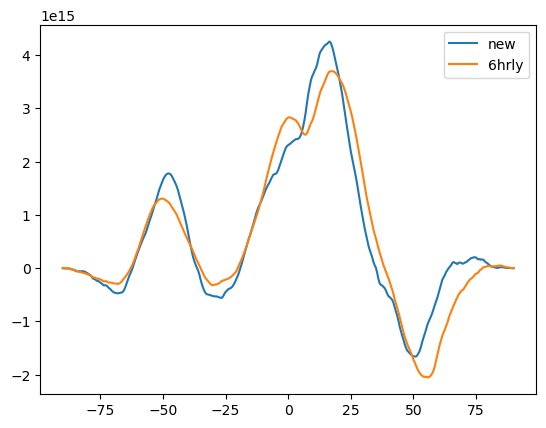

In [35]:
plt.plot(lats, np.mean(mmc_aht_test, axis=0), label='new')
plt.plot(lats, aht_ds.mmc_aht.sel(time=slice('2018-01-01', '2018-01-30')).mean(['time']), label='6hrly')

plt.legend(loc=0)
plt.show()